## **Задача**

Построить  алгоритм, который для каждой пары пользователь-услуга определит вероятность подключения услуги.

## **Данные**

1. Информация об отклике абонентов на предложение подключения одной из услуг. Каждому пользователю может быть сделано несколько предложений в разное время, каждое из которых он может или принять, или отклонить.
2. Нормализованный анонимизированный набор признаков, характеризующий профиль потребления абонента. Эти данные привязаны к определенному времени, поскольку профиль абонента может меняться с течением времени.

Данные train и test разбиты по периодам — на train доступно 4 месяца, а на test отложен последующий месяц. 

TRAIN DATA:

+ data_train.csv: id, vas_id, buy_time, target.
+ features.csv.zip: id, feature_list.

TEST DATA:
+ data_test.csv: id, vas_id, buy_time.

FEATURES:

+ **target** — целевая переменная, где 1 означает подключение услуги, 0 - абонент не подключил услугу соответственно. 
+ **buy_time** — время покупки, представлено в формате timestamp.
+ **id** — идентификатор абонента.
+ **vas_id** — подключаемая услуга.

## **Метрика**
Функция **f1**, невзвешенным образом, как например делает функция sklearn.metrics.f1_score(…, average=’macro’).

In [4]:
# Подключим библиотеки
import pandas as pd
import numpy as np
import sklearn
import datetime
import itertools
# import dask.dataframe as dd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split, KFold, cross_validate, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline
from sklearn.metrics import precision_recall_curve, roc_curve, auc, confusion_matrix, classification_report
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.feature_selection import SelectFromModel
from sklearn.decomposition import TruncatedSVD
from sklearn.compose import ColumnTransformer
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler
import lightgbm as lgb
import pickle
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# Зафиксируем значение random_state для воспроизводимости результатов
RANDOM_STATE = 42

##### **Вспомогательные функции и классы**

In [13]:
# Функция для уменьшения используемой памяти данными
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df
  

# Функция для вычисления результата кросс-валидации
def run_cv(estimator, cv, X, y, scoring='f1_macro', model_name=''):
    cv_result = cross_validate(estimator, X, y, cv=cv, scoring=scoring)
    
    print('%s: %s = %0.2f (+/- %0.2f)' % (model_name,
                                         scoring,
                                         cv_result['test_score'].mean(),
                                         cv_result['test_score'].std() * 2))
    

# Функция для построения графика ROC кривой
def plot_roc_curve(fpr, tpr, model_name='', color=None):
    plt.plot(fpr, tpr, label='%s: ROC curve (area = %0.2f)' %
             (model_name, auc(fpr, tpr)), color=color)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0.0, 1.0, 0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('%s: Receiver operating characteristic curve' % model_name)
    plt.legend(loc='lower right')


# Функция для построения графика PR кривой
def plot_precision_recall_curve(recall, precision, model_name='', color=None):
    plt.plot(recall, precision, label='%s: Precision-Recall curve (area = %0.2f)' %
             (model_name, auc(recall, precision)), color=color)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('%s: Precision-Recall curve' % model_name)
    plt.axis([0.0, 1.0, 0.0, 1.05])
    plt.legend(loc='lower left')


# Функция для построения графика Матрицы смежности
def plot_confusion_matrix(cm, classes,
                          model_name="",
                          normalize=False,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print('Normalized confusion matrix')
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest',  cmap=cmap)
    
    plt.grid(False)
    plt.title('%s: confusion matrix' % model_name)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment='center',
                 color="white" if cm[i, j] > thresh else 'black')

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


# Функция для поиска параметров по сетке
def run_grid_search(estimator, X, y, params_grid, cv, scoring='f1_macro'):
    gsc = GridSearchCV(estimator, params_grid, scoring=scoring, cv=cv, n_jobs=-1)

    gsc.fit(X, y)
    print('Best %s score: %.2f' % (scoring, gsc.best_score_))
    print()
    print('Best parameters set found on development set:')
    print()
    print(gsc.best_params_)
    print()
    print('Grid scores on development set:')
    print()

    for i, params in enumerate(gsc.cv_results_['params']):
        print('%0.3f (+/-%0.03f) for %r'
              % (gsc.cv_results_['mean_test_score'][i], gsc.cv_results_['std_test_score'][i] * 2, params))

    print()
    
    return gsc

  
# Функция для обучения модели и построения отчета по предсказаниям
def model_report(X_train, y_train, X_test, pipeline_name):
    model_final = pipeline_name
    model_final.fit(X_train, y_train)
    y_pred = model_final.predict_proba(X_test)[:,1]

    return y_pred

In [14]:
# Класс Трансформер для выделения колонок
class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        assert isinstance(X, pd.DataFrame)

        try:
            return X[self.columns]
        except KeyError:
            cols_error = list(set(self.columns) - set(X.columns))
            raise KeyError('DataFrame не содержит следующие колонки: %s' % cols_error)

## **Загрузим данные**

In [5]:
# Создадим переменные путей
PATH_DATA_TRAIN = 'data_train.csv'
PATH_DATA_TEST = 'data_test.csv'
# PATH_FEATURES = 'features.csv'
# PATH_TRAIN_FEATURES = 'id_features.csv'
PATH_TRAIN_MERGE_FEATURES = 'train_merge_features.csv'

In [6]:
# Прочитаем данные
data_train = pd.read_csv(PATH_DATA_TRAIN).drop('Unnamed: 0', axis=1)
data_test = pd.read_csv(PATH_DATA_TEST).drop('Unnamed: 0', axis=1)
data_train.shape, data_test.shape

((831653, 4), (71231, 3))

In [7]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 831653 entries, 0 to 831652
Data columns (total 4 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   id        831653 non-null  int64  
 1   vas_id    831653 non-null  float64
 2   buy_time  831653 non-null  int64  
 3   target    831653 non-null  float64
dtypes: float64(2), int64(2)
memory usage: 25.4 MB


In [8]:
# Изменим формат даты
data_train['buy_time'] = pd.to_datetime(data_train['buy_time'], unit='s')

In [9]:
data_train.head()

,id,vas_id,buy_time,target
0,540968,8.0,2018-09-16 21:00:00,0.0
1,1454121,4.0,2018-07-15 21:00:00,0.0
2,2458816,1.0,2018-08-12 21:00:00,0.0
3,3535012,5.0,2018-09-02 21:00:00,0.0
4,1693214,1.0,2018-09-02 21:00:00,0.0


In [7]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71231 entries, 0 to 71230
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        71231 non-null  int64  
 1   vas_id    71231 non-null  float64
 2   buy_time  71231 non-null  int64  
dtypes: float64(1), int64(2)
memory usage: 1.6 MB


In [ ]:
# # Прочитаем данные признаков
# data_features = dd.read_csv(PATH_FEATURES, sep='\t')

In [ ]:
# data_features.head()

In [ ]:
# %%time
# # Выберем признаки по id
# id_features = data_features[data_features['id'].isin(data_train['id']) == True].compute()
# id_features = id_features.drop('Unnamed: 0', axis=1)

In [ ]:
# %%time
# # Сохраним выборку
# id_features.to_csv('PATH_TRAIN_FEATURES')

In [ ]:
# # Считаем файл с отобранными признаками
# id_features = pd.read_csv(PATH_TRAIN_FEATURES).drop('Unnamed: 0', axis=1)
# id_features['buy_time'] = pd.to_datetime(id_features['buy_time'])

In [ ]:
# id_features.head()

In [ ]:
# id_features.info()

In [ ]:
# # Отсортируем признаки по времени для дальнейшей операции присоединения
# data_train = data_train.sort_values(by='buy_time')
# id_features = id_features.sort_values(by='buy_time')

In [ ]:
# %%time
# # Соединим таблицы по id и времени, при этом время в признаках должно быть меньше чем время предложения клиенту услуги, сохраним только заполненные строки
# id_merge_train = pd.merge_asof(data_train, id_features, on='buy_time', by='id', direction='backward')
# id_merge_train = id_merge_train[id_merge_train['0'].notnull()]ф

In [ ]:
# # Количество строк сократилось
# id_merge_train.info()

In [ ]:
# # Сделаем проверку присоединенных таблиц по времени
# # Выберем id, у которого есть несколько профилей
# id_features[id_features[['id']].id.duplicated() == True][['id', 'buy_time', '0']].head(1)

In [ ]:
# # Найдем оба профиля
# id_features[id_features['id'] == 2261406][['id', 'buy_time', '0']]

In [ ]:
# # В собранной таблице присоединен признак '0' со знакние -31.929971, он относится ко времени '2018-07-15 21:00:00'
# # Присоединение произошло верно, при этом выбран более поздний профиль из двух
# id_merge_train[id_merge_train['id'] == 2261406][['id', 'buy_time', '0']]

In [ ]:
# %%time
# # Сохраним выборку
# id_merge_train.to_csv(PATH_TRAIN_MERGE_FEATURES)

In [10]:
# Считаем файл объединенных таблиц
id_merge_train = pd.read_csv(PATH_TRAIN_MERGE_FEATURES).drop('Unnamed: 0', axis=1)

In [15]:
# Уменьшим объем датафрейма
reduce_mem_usage(id_merge_train)

Memory usage of dataframe is 801.41 MB
Memory usage after optimization is: 399.54 MB
Decreased by 50.1%


,id,vas_id,buy_time,target,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,...,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252
0,3532789,1.0,2018-07-08 21:00:00,0.0,-30.349970,-139.569107,-44.290787,-192.176804,-49.708248,-213.281784,-16.08618,-65.076096,-6.78366,-30.006538,-2.736081,-4.007526,-2.558912,-1.859127,-13.188110,-0.000725,-0.016435,-0.107041,-5.41746,-1.058521,-13.940815,-10.744164,-0.094251,-0.001733,-0.009327,-2.082209,0.200138,-0.00909,-0.351862,-0.214366,-0.211608,-0.001884,-0.000023,-0.00003,-2.659389,-0.065583,...,-42051.167969,-9239.707031,-2.10805,-0.000083,2.377104,-0.00004,2.379228,-0.012257,-0.107878,958932480.0,-49.354080,-4.405604e+08,-120441800.0,-11.026593,-1.465191,-33.30238,-266.128998,-39.772491,-0.364694,-0.133771,-0.209468,-35.356506,-109.884567,-876.69104,-5.368281,-247.110703,-108.409744,-512.437317,-106.617981,-17.295406,-977.373840,-613.770813,-25.996269,-37.630447,-306.747711,-25.832888,-0.694429,-12.175933,-0.45614,0.0
1,167964,4.0,2018-07-08 21:00:00,0.0,280.330017,47.670887,266.389221,-4.936798,265.211761,28.998211,-16.08618,-15.856097,-6.78366,17.189095,-2.736081,-4.007526,-2.558912,221.950867,299.611877,-0.000725,-0.016435,-0.107041,-1.17746,-3.178521,-13.940815,-10.744164,-0.094251,-0.001733,-0.009327,-2.082209,0.200138,-0.00909,-0.351862,-0.214366,-0.211608,-0.001884,-0.000023,-0.00003,-2.659389,-0.065583,...,-42051.167969,-9239.707031,-2.10805,-0.000083,1.377104,-0.00004,1.379228,-0.012257,-0.107878,958414080.0,229.595917,-4.405604e+08,-120441800.0,4.756475,-1.465191,-33.30238,-242.128983,-33.772491,-0.364694,-0.133771,-0.209468,-29.356504,-109.884567,-637.69104,-5.368281,-231.110703,-108.409744,-289.437317,-98.617981,-17.295406,-977.373840,-613.770813,-25.996269,-37.630447,-237.747726,-20.832888,-0.694429,-7.175933,-0.45614,0.0
2,4236220,1.0,2018-07-08 21:00:00,0.0,-96.799973,49.440887,-110.740784,-3.166798,-116.158249,-24.271790,-16.08618,-65.076096,-6.78366,-30.006538,-2.736081,-4.007526,-2.558912,-66.189125,-77.518112,-0.000725,-0.016435,-0.107041,-5.41746,-3.178521,-13.940815,-10.744164,-0.094251,-0.001733,-0.009327,-2.082209,0.200138,-0.00909,-0.351862,-0.214366,-0.211608,-0.001884,-0.000023,-0.00003,-2.659389,-0.065583,...,-41541.167969,-9239.707031,-2.10805,-0.000083,-0.622896,-0.00004,-0.620772,-0.012257,-0.107878,-572669504.0,-58.544079,1.084806e+09,-120441800.0,4.327904,-1.465191,-33.30238,-263.128998,-39.772491,-0.364694,-0.133771,-0.209468,-35.356506,-109.884567,-876.69104,-5.368281,-247.110703,-108.409744,-512.437317,-60.617977,-17.295406,-903.373840,-539.770813,-25.996269,-37.630447,-290.747711,-25.832888,-0.694429,-12.175933,-0.45614,1.0
3,3883492,4.0,2018-07-08 21:00:00,0.0,-92.139969,-46.319111,-106.080788,61.243202,-111.498245,40.138210,-16.08618,-65.076096,-6.78366,-30.006538,-2.736081,-4.007526,-2.558912,-66.189125,-74.978111,-0.000725,-0.016435,-0.107041,-5.41746,-1.058521,-13.940815,-10.744164,-0.094251,-0.001733,-0.009327,-2.082209,0.200138,-0.00909,-0.351862,-0.214366,-0.211608,-0.001884,-0.000023,-0.00003,-2.659389,-0.065583,...,-41101.167969,-9239.707031,-2.10805,-0.000083,-0.622896,-0.00004,-0.620772,-0.012257,-0.107878,-572669504.0,-58.544079,1.085484e+09,-120441800.0,8.099333,-1.465191,-33.30238,-199.128983,48.227509,-0.364694,-0.133771,-0.209468,50.643494,-109.884567,-437.69101,-2.368281,164.889297,-108.409744,-488.437317,181.382019,-16.295406,-969.373840,-613.770813,-24.996269,-37.630447,1699.252319,-20.832888,1.305572,-9.175933,-0.45614,1.0
4,2847225,1.0,2018-07-08 21:00:00,0.0,464.210022,428.250885,450.269226,375.643188,444.851746,354.538208,-16.08618,-65.076096,-6.78366,-30.006538,-2.736081,-4.007526,-2.558912,484.660858,473.331879,-0.000725,-0.016435,-0.107041,-5.41746,6.981479,-13.940815,-10.744164,-0.094251,-0.001733,-0.009327,-2.082209,0.200138,-0.00909,-0.351862,-0.214366,-0.211608,-0

In [16]:
id_merge_train['buy_time'].value_counts(sort=False)

2018-07-08 21:00:00      373
2018-07-15 21:00:00     2485
2018-07-22 21:00:00     6708
2018-07-29 21:00:00     4067
2018-08-05 21:00:00     9397
2018-08-12 21:00:00     9315
2018-08-19 21:00:00     9932
2018-08-26 21:00:00     9862
2018-09-02 21:00:00     8376
2018-09-09 21:00:00    12290
2018-09-16 21:00:00    12828
2018-09-23 21:00:00    12109
2018-09-30 21:00:00    12104
2018-10-07 21:00:00    11395
2018-10-14 21:00:00    12439
2018-10-21 21:00:00    11778
2018-10-28 21:00:00    12740
2018-11-04 21:00:00    12639
2018-11-11 21:00:00    11260
2018-11-18 21:00:00    14910
2018-11-25 21:00:00     7712
2018-12-02 21:00:00     6824
2018-12-09 21:00:00    31067
2018-12-16 21:00:00    76450
2018-12-23 21:00:00    47101
2018-12-30 21:00:00    42563
Name: buy_time, dtype: int64

In [17]:
id_merge_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 408724 entries, 0 to 408723
Columns: 257 entries, id to 252
dtypes: category(1), float32(255), int32(1)
memory usage: 399.5 MB


In [18]:
# Пропущенных значений в датасете нет
print('Процент значения null: %d%%' % float((id_merge_train.isnull().sum() > 0).sum()/id_merge_train.shape[1]*100))

# Заменим дату обратно на формат timestamp
id_merge_train['buy_time'] = pd.to_datetime(id_merge_train['buy_time']).astype(np.int64) // 10 ** 9

Процент значения null: 0%


In [19]:
# Посмотрим на соотношение целевой переменной
# Наблюдается большой перевес нулевого класса
id_merge_train['target'].value_counts()/id_merge_train['target'].shape

0.0    0.909252
1.0    0.090748
Name: target, dtype: float64

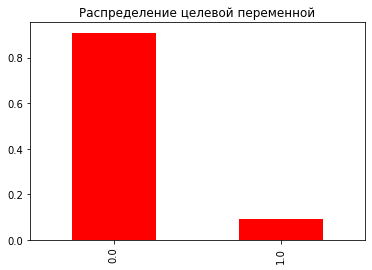

In [20]:
# Построим график
(id_merge_train['target'].value_counts()/id_merge_train['target'].shape).plot(kind='bar', title='Распределение целевой переменной', color='red')
plt.show()

### **Разделим данные на TRAIN и TEST**

In [21]:
# Разделим данные на train и test по временному принципу, 
# то есть на train оставить данные до '2018-12-23 21:00:00', а на test - после
# получится примерно 28% выборки на test (для проверки предсказаний)

temp_train = id_merge_train[id_merge_train['buy_time'] < 1545598800]
temp_test = id_merge_train[id_merge_train['buy_time'] >= 1545598800]

# Разделим признаки и целевую переменную
y_train = temp_train['target']
X_train = temp_train.drop('target', axis=1)

y_test = temp_test['target']
X_test= temp_test.drop('target', axis=1)

print('Train')
print(y_train.value_counts()/y_train.shape[0])
print(X_train.shape, y_train.shape)
print()
print('Test')
print(y_test.value_counts()/y_test.shape[0])
print(X_test.shape, y_test.shape)

Train
0.0    0.904231
1.0    0.095769
Name: target, dtype: float64
(319060, 256) (319060,)

Test
0.0    0.927117
1.0    0.072883
Name: target, dtype: float64
(89664, 256) (89664,)


### **Сделаем Pipeline для Baseline модели**

In [22]:
# Используем для построения Baseline модели логистическую регрессию
# Добавим Baseline модель в Pipeline
bl_lg_estimator = Pipeline([
    ('log_reg', LogisticRegression(random_state=RANDOM_STATE))
])

### **Оценим качество модели с помощью Кросс-валидации**

In [23]:
# Построим кросс-валидацию на 5-ти фолдах
# В качестве метрики будет f1_macro
kfold_cv = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

In [24]:
# # Посмотрим на базовую метрику
# run_cv(bl_lg_estimator, kfold_cv, X_train, y_train, model_name='Baseline')

# # Baseline: f1_macro = 0.47 (+/- 0.00)

In [25]:
# Создадим таблицу для сравнения моделей
compare_table = pd.DataFrame({
    'Model_name': ['Baseline_LogisticRegression'],
    'Pipeline_name': 'bl_lg_estimator',
    'F1_macro': [0.47],
    'Best_params': '-'
    })

In [26]:
compare_table

,Model_name,Pipeline_name,F1_macro,Best_params
0,Baseline_LogisticRegression,bl_lg_estimator,0.47,-


### **Построим графики и метрики Baseline модели для тестовых данных**

In [27]:
# Обучим модель и предскажем таргет
bl_lg_estimator.fit(X_train, y_train)
bl_y_pred = bl_lg_estimator.predict_proba(X_test)[:,1]

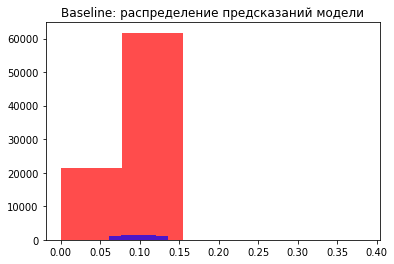

In [28]:
# Посмотрим на распределение предсказаний Baseline модели
plt.title('Baseline: распределение предсказаний модели')
plt.hist(bl_y_pred[~y_test.astype(bool)], bins=5, color='r', alpha=0.7);
plt.hist(bl_y_pred[y_test.astype(bool)], bins=5, color='b', alpha=0.7);

In [29]:
# Построим ROC и PR кривые
fpr, tpr, roc_thresholds = roc_curve(y_test, bl_y_pred)
precision, recall, pr_thresholds = precision_recall_curve(y_test, bl_y_pred)

Baseline: AUC_ROC = 0.562


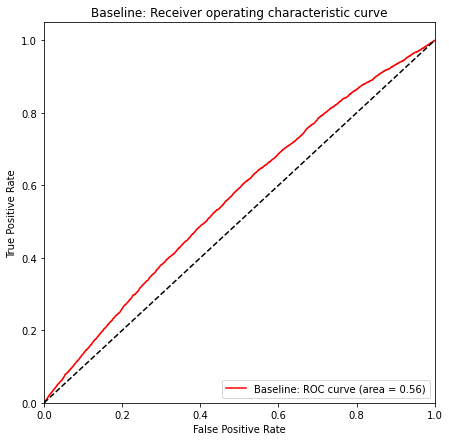

In [30]:
# Кривая базовой модели проходит выше диагонали,
# следовательно наша модель работает лучше, чем случаное предсказание
plt.figure(figsize=(7, 7))
plot_roc_curve(fpr, tpr, 'Baseline', color='r')
print('Baseline: AUC_ROC = %.3f' % auc(fpr, tpr))

Baseline: AUC_PR = 0.087


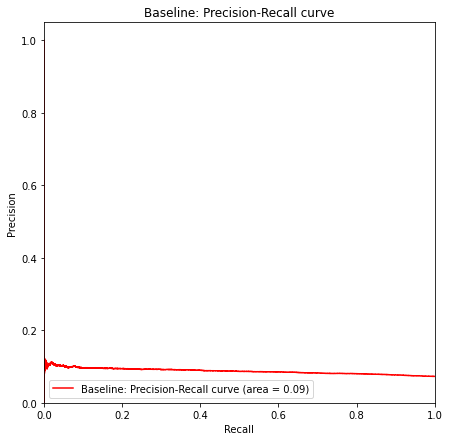

In [31]:
plt.figure(figsize=(7, 7))    
plot_precision_recall_curve(recall, precision, 'Baseline', color='r')
print('Baseline: AUC_PR = %.3f' % auc(recall, precision))

Confusion matrix, without normalization
[[83129     0]
 [ 6535     0]]


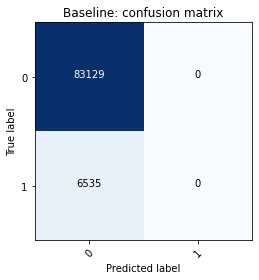

In [32]:
# Построим матрицу смежности
# TN                FP(Type II error)
# 
# FN(Type I error)  TP

# На данном этапе поставим порог отнесения предсказаний к 1-му классу 0.5
cm = confusion_matrix(y_test, bl_y_pred > 0.5)
plot_confusion_matrix(cm, classes=['0', '1'], model_name='Baseline');

In [33]:
# Построим отчет
print(classification_report(y_test, bl_y_pred > 0.5))

              precision    recall  f1-score   support

         0.0       0.93      1.00      0.96     83129
         1.0       0.00      0.00      0.00      6535

    accuracy                           0.93     89664
   macro avg       0.46      0.50      0.48     89664
weighted avg       0.86      0.93      0.89     89664



### **Рассмотрим признаки подробнее и определим их типы**

In [34]:
# Оставим в датасете только уникальные значения
X_nunique = X_train.apply(lambda x: x.nunique(dropna=False))
X_nunique.shape

(256,)

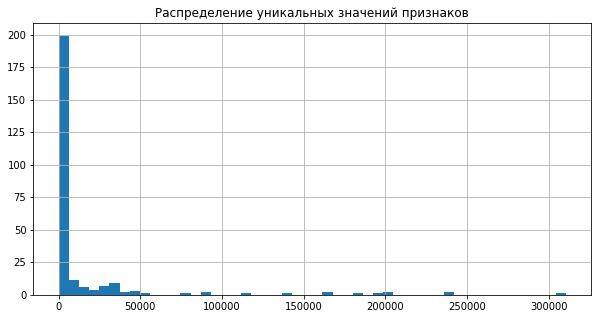

In [35]:
# Из графика видно, что есть признаки, у которых мало уникальных значений, а есть - у которых много. 
# Скорее всего, где много значений - это вещественные признаки, 
# а где мало - это категориальные, integer или бинарные признаки
plt.title('Распределение уникальных значений признаков')
X_nunique.hist(bins=50, figsize=(10, 5));

In [36]:
# Выделим названия всех признаков
f_all = set(X_nunique.index.tolist())

# Найдем константные признаки
f_const = set(X_nunique[X_nunique == 1].index.tolist())

# Найдем вещественные признаки
f_numeric = (X_train.fillna(0).astype(int).sum() - X_train.fillna(0).sum()).abs()
f_numeric = set(f_numeric[f_numeric > 0].index.tolist())

# Найдем сколько осталось признаков
f_other = f_all - (f_numeric | f_const)

# Найдем бинарные признаки
f_binary = set(X_train.loc[:, f_other].columns[(
                      (X_train.loc[:, f_other].max() == 1) & \
                      (X_train.loc[:, f_other].min() == 0) & \
                      (X_train.loc[:, f_other].isnull().sum() == 0))])

f_other = f_other - f_binary

# Найдем категориальные признаки
f_categorical = set(X_nunique.loc[f_other][X_nunique.loc[f_other] <= 10].index.tolist())

f_other = f_other - f_categorical

f_numeric = f_numeric | f_other
f_other = f_other - f_numeric
len(f_other)

0

In [37]:
# Сделаем проверку 
assert(X_nunique.shape[0] == len(f_const) + len(f_binary) + len(f_numeric) + len(f_categorical))

In [38]:
print('ПРИЗНАКИ')
print()
print('Всего:', X_train.shape[1])
print()
print('Константные:', len(f_const))
print('Бинарные:', len(f_binary))
print('Категориальные:', len(f_categorical))
print('Вещественные:', len(f_numeric))

f_ok = list(f_binary | f_categorical | f_numeric)
f_binary, f_categorical, f_numeric = list(f_binary), list(f_categorical), list(f_numeric)

ПРИЗНАКИ

Всего: 256

Константные: 5
Бинарные: 0
Категориальные: 1
Вещественные: 250


### **Создадим Pipeline для обработки признаков**

In [39]:
# OneHotEncoder(handle_unknown='ignore') - игнорируем значение, 
# которого не было при обучении
f_prep_pipe = make_pipeline(
    ColumnSelector(columns=f_ok),
    FeatureUnion(transformer_list=[
        ('numeric_features', make_pipeline(
            ColumnSelector(f_numeric),
            StandardScaler()
        )),
        ('categorical_features', make_pipeline(
            ColumnSelector(f_categorical),
            OneHotEncoder(handle_unknown='ignore')
        ))      
    ])
)

In [40]:
# Посмотрим на шаги Pipeline
f_prep_pipe.steps

[('columnselector',
  ColumnSelector(columns=['67', '82', '91', '234', '158', '209', '198', '172',
                          '194', '31', '235', '72', '106', '237', '164', '18',
                          '56', '221', '216', '47', '104', '55', '242', 'vas_id',
                          '0', '87', '33', '79', '148', '156', ...])),
 ('featureunion', FeatureUnion(transformer_list=[('numeric_features',
                                  Pipeline(steps=[('columnselector',
                                                   ColumnSelector(columns=['67',
                                                                           '82',
                                                                           '91',
                                                                           '234',
                                                                           '158',
                                                                           '209',
                                         

In [41]:
# Количество признаков до обработки
X_test.shape[1]

256

In [42]:
# Количество признаков после обработки
f_prep_pipe.fit(X_train)
n_features = f_prep_pipe.transform(X_test).shape[1]
n_features

258

### **Выполним поиск по сетке (Gridsearch) для Pipeline**

In [43]:
# Построим новый Pipeline с предобработкой признаков
lg_pipe = make_pipeline(
    f_prep_pipe,
    LogisticRegression(random_state=RANDOM_STATE)
)

In [45]:
# Посмотрим на параметры модели
[k for k in lg_pipe.get_params().keys() if 'logisticregression' in k]

['logisticregression',
 'logisticregression__C',
 'logisticregression__class_weight',
 'logisticregression__dual',
 'logisticregression__fit_intercept',
 'logisticregression__intercept_scaling',
 'logisticregression__l1_ratio',
 'logisticregression__max_iter',
 'logisticregression__multi_class',
 'logisticregression__n_jobs',
 'logisticregression__penalty',
 'logisticregression__random_state',
 'logisticregression__solver',
 'logisticregression__tol',
 'logisticregression__verbose',
 'logisticregression__warm_start']

In [ ]:
# # Добавим параметры для логистической регрессии для поиска по сетке
# param_grid = {
#     'logisticregression__penalty': ['l1', 'l2'],
#     'logisticregression__C': [0.01, 0.1, 1.0]
# }

# lg_gsc = run_grid_search(lg_pipe, X_train, y_train, param_grid, kfold_cv)

# # Best f1_macro score: 0.61
# # Best parameters set found on development set:
# # {'logisticregression__C': 1.0, 'logisticregression__penalty': 'l2'}
# # Grid scores on development set:
# # nan (+/-nan) for {'logisticregression__C': 0.01, 'logisticregression__penalty': 'l1'}
# # 0.597 (+/-0.005) for {'logisticregression__C': 0.01, 'logisticregression__penalty': 'l2'}
# # nan (+/-nan) for {'logisticregression__C': 0.1, 'logisticregression__penalty': 'l1'}
# # 0.607 (+/-0.005) for {'logisticregression__C': 0.1, 'logisticregression__penalty': 'l2'}
# # nan (+/-nan) for {'logisticregression__C': 1.0, 'logisticregression__penalty': 'l1'}
# # 0.608 (+/-0.005) for {'logisticregression__C': 1.0, 'logisticregression__penalty': 'l2'}

In [44]:
compare_table.loc[1] = ['Prep_features_LogisticRegression', 
                        'lg_pipe', 
                        0.61, 
                        "{'logisticregression__C': 1.0, 'logisticregression__penalty': 'l2'}"]

In [46]:
# С предобработкой признаков метрика улучшилась, 
# при этом параметры для логистической регрессии оказались лучше всего по умолчанию
compare_table

,Model_name,Pipeline_name,F1_macro,Best_params
0,Baseline_LogisticRegression,bl_lg_estimator,0.47,-
1,Prep_features_LogisticRegression,lg_pipe,0.61,"{'logisticregression__C': 1.0, 'logisticregres..."


### **Отберем значимые признаки в Pipeline**

In [47]:
# Воспользуемся классом SelectFromModel для отбора значимых признаков
# Атрибут estimator класса SelectFromModel должен иметь хотя бы один из атрибутов 
# feature_importances_ или coef_ после выполнения метода fit

fs_pipe = make_pipeline(
    f_prep_pipe,
    SelectFromModel(LogisticRegression(penalty='l2', random_state=RANDOM_STATE, solver='sag'), threshold=1e-3),
)

In [48]:
# f_prep_pipe.fit(X_train)
# f_prep_pipe.transform(X_test).shape
# # (89664, 258)

In [49]:
# # Логистическая регрессия из SelectFromModel обнулила 246 признаков при пороге 1e-2.
# fs_pipe.fit(X_train, y_train)
# fs_pipe.transform(X_test).shape
# # (89664, 12)

In [50]:
# # Логистическая регрессия из SelectFromModel обнулила 73 признака при пороге 1e-3.
# fs_pipe.fit(X_train, y_train)
# fs_pipe.transform(X_test).shape
# # (89664, 185)

In [51]:
fs_lg_pipe = make_pipeline(
    f_prep_pipe,
    SelectFromModel(LogisticRegression(penalty='l2', random_state=RANDOM_STATE, solver='sag'), threshold=1e-2),
    LogisticRegression(random_state=RANDOM_STATE)
)

In [52]:
# param_grid = [
#     {'selectfrommodel__threshold': [1e-2, 1e-3]},
# ]

# fs_lg_gsc = run_grid_search(fs_lg_pipe, X_train, y_train, param_grid, kfold_cv)

# # Best f1_macro score: 0.61
# # Best parameters set found on development set:
# # {'selectfrommodel__threshold': 0.001}
# # Grid scores on development set:
# # 0.607 (+/-0.005) for {'selectfrommodel__threshold': 0.01}
# # 0.608 (+/-0.004) for {'selectfrommodel__threshold': 0.001}

In [53]:
# Несмотря на то, что модель показала лучшим показателем порог 0.001,
# для модели возьмем порог 0.01, так как при нем отсекается больше признаков,
# а точность меньше всего на 0.001
compare_table.loc[2] = ['Prep_f_SelectFromModel_LogisticRegression', 
                        'fs_lg_pipe', 
                        0.61, 
                        "{'selectfrommodel__threshold': 0.01}"]

In [54]:
compare_table

,Model_name,Pipeline_name,F1_macro,Best_params
0,Baseline_LogisticRegression,bl_lg_estimator,0.47,-
1,Prep_features_LogisticRegression,lg_pipe,0.61,"{'logisticregression__C': 1.0, 'logisticregres..."
2,Prep_f_SelectFromModel_LogisticRegression,fs_lg_pipe,0.61,{'selectfrommodel__threshold': 0.01}


### **Попробуем уменьшить размерность датасета**

In [55]:
# # Воспользуемся классом TruncatedSVD для уменьшения размерности датасета
# tsvd = TruncatedSVD(n_components=100, random_state=RANDOM_STATE)
# X_train_tsvd = tsvd.fit_transform(X_train.iloc[:,3:])
# X_train_tsvd = pd.DataFrame(X_train_tsvd)
# X_train_tsvd.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
0,739214976.0,-7.522922e+08,-125573664.0,84329.257812,-34981.000000,-5646.236328,-55131.632812,7644.680176,-7383.424805,-424.858856,433.364197,64.135391,-670.702393,-387.085632,51.740211,5129.151367,-1525.474731,-786.715698,-468.378815,89.974533,-55.117603,-62.675938,-39.223164,-48.884388,210.422073,117.342476,179.947510,-124.560600,83.460999,65.829720,-42.668179,71.182030,122.512291,129.935349,173.417023,-141.783722,-20.333353,83.363144,-48.736599,-306.848389,...,-49.381748,-11.185049,-0.799784,0.046331,-23.177216,59.814358,-28.935644,-14.242103,-19.690519,-33.378155,-7.127100,-1.725168,-6.934814,-11.874169,5.160461,5.897686,-17.721193,-36.958027,17.676792,13.608834,2.531169,-4.663638,-15.334394,23.670984,32.411491,-0.722059,-6.045660,9.893386,-9.697067,22.718763,5.952734,-15.212498,27.864498,7.152301,-0.925163,-8.306300,-10.503601,18.615797,5.941054,9.581104
1,738729664.0,-7.521104e+08,-125561168.0,84254.859375,-35137.203125,-5638.344727,-31426.833984,-7495.925293,-7332.713867,-429.770660,256.056183,-54.029633,-161.305527,-459.268433,108.310959,99.854858,-2.280917,304.700134,-274.572113,78.933174,-132.576523,-39.144314,-15.630346,11.148090,-43.413422,169.109680,146.474426,-263.281403,164.477676,-41.871807,-118.901474,29.731295,-196.535980,-3.107517,178.910858,-60.315582,-2.626957,-251.492004,3.295929,81.711166,...,-20.531301,7.979831,18.535423,12.889177,-12.294456,33.437981,23.157642,-15.122996,0.995174,2.612254,-57.571972,11.827717,22.930023,-3.322587,-28.574892,1.182083,1.045183,-27.453411,-11.058435,3.881615,5.955949,1.220250,0.327420,5.561301,-12.025873,36.159199,-26.544260,6.199272,4.960034,38.173981,-16.991611,16.492125,-20.078434,25.267590,6.327606,-13.165543,0.642967,-2.110659,12.278786,13.999861
2,-161191344.0,1.212700e+09,-150450032.0,-87310.460938,-22680.210938,-5293.679688,-22639.761719,9549.570312,-4559.834961,31.125517,162.363892,-175.981354,-540.540588,-214.046509,29.790806,-175.985016,-51.147366,-41.044956,-48.378239,75.539017,-39.892696,33.604534,-33.296097,-8.531073,-57.500065,127.749336,354.858032,53.580669,11.532738,20.277651,30.483376,11.738135,11.471357,7.324958,-52.761894,13.928021,-33.099926,48.670303,-23.061419,-29.971468,...,18.819338,-6.508221,-6.975789,2.665164,6.135558,-15.557881,1.975291,12.726208,0.641769,8.972052,13.617270,-1.209049,15.540384,1.278806,-1.579904,4.149377,8.715479,35.684280,-20.231421,5.321735,8.063858,7.033295,13.798428,19.822027,20.025789,-6.762045,4.369853,-1.014777,4.566218,-19.564125,0.989805,2.166638,5.178129,10.308695,6.776455,4.328171,7.651372,-8.666777,1.270321,2.883238
3,-160954160.0,1.213335e+09,-150477504.0,-86872.656250,-22683.324219,-5290.806641,-22777.333984,-21695.361328,768.446594,-189.424561,1176.125122,-361.066467,-320.409180,6.810396,-126.815720,-95.844772,643.293030,-465.922974,-540.660278,-636.782471,-50.543343,-179.041550,1240.677734,232.139160,346.835571,-480.207397,400.184082,-68.773224,-5.340913,-163.563385,185.479416,-10.974185,144.977478,-194.254532,-226.696091,154.444321,-112.394012,129.902939,6.158668,256.714020,...,24.719856,11.021063,-73.793564,-4.502439,-7.327885,0.911343,-14.112989,4.688716,-5.484852,7.984852,-2.216877,-3.527642,-1.945136,6.857720,8.047891,4.355283,4.716278,26.378132,-21.635273,-0.929419,6.860773,-1.317157,12.880483,-2.665663,-12.494123,3.280395,16.432735,18.148956,3.945563,-6.013452,8.403618,6.805453,-4.814251,12.088217,18.096294,11.138045,9.516119,-6.902594,1.594602,0.300044
4,739214976.0,-7.522922e+08,-125573664.0,84326.992188,-34998.062500,-5645.133789,-31066.738281,10011.466797,11382.993164,-1894.649292,-7830.158691,5800.660156,-3397.874268,-550.082642,326.628540,140.402725,-751.257141,547.139404,248.384857,125.218704,1303.581665,808.721436,170.840057,-486.081573,-557.427002,84.233597,62.24243

In [56]:
# # Первые три компоненты передают более 99% информации,
# # можно попробовать построить модель только на них
# explained_variance = tsvd.explained_variance_ratio_
# cum_var_exp = np.cumsum(explained_variance)
# cum_var_exp[:10]

array([0.4574953 , 0.8570673 , 0.99960333, 0.9999502 , 1.000052  ,
       1.0000575 , 1.0000575 , 1.0000575 , 1.0000575 , 1.0000575 ],
      dtype=float32)

In [57]:
# X_train_tsvd['target'] = y_train

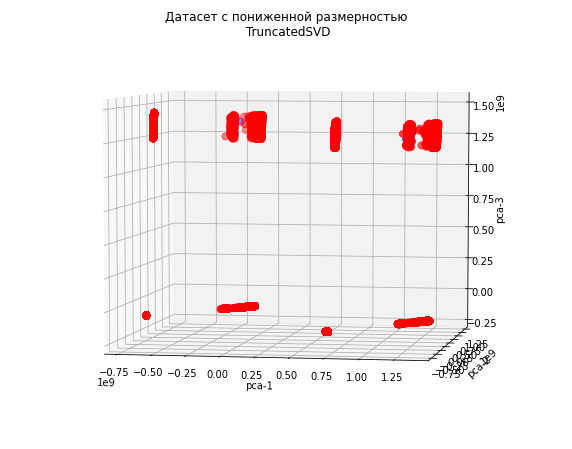

In [66]:
# ax = plt.figure(figsize=(10, 8)).gca(projection='3d')
# targets = [0, 1]
# colors = ['r', 'b']
# for target, color in zip(targets,colors):
#  indicesToKeep = X_train_tsvd['target'] == target
#  ax.scatter(X_train_tsvd.loc[indicesToKeep, 0]
#  , X_train_tsvd.loc[indicesToKeep, 1] 
#  , X_train_tsvd.loc[indicesToKeep, 2]
#  , c = color
#  , s = 50)
# ax.set_xlabel('pca-1')
# ax.set_ylabel('pca-2')
# ax.set_zlabel('pca-3')
# ax.view_init(5, -80)
# plt.title('Датасет с пониженной размерностью\n TruncatedSVD')
# plt.savefig('TruncatedSVD.png', transparent=True)
# plt.show()

In [59]:
# # Применим метод главных компонент только на признаках профиля клиента


# col_tsvd_transformer = make_pipeline(
#     ColumnTransformer(
#         remainder='passthrough', #passthough чтобы попали также нетрансформированные признаки
#         transformers=[
#             ('tsvd', TruncatedSVD(n_components=4, random_state=RANDOM_STATE) ,  X_train.iloc[:, 3:].columns)
#         ])
#     )

In [60]:
# tsvd_lg_pipe = make_pipeline(
#     col_tsvd_transformer,
#     LogisticRegression(random_state=RANDOM_STATE)
# )

In [61]:
# param_grid = [
#     {'pipeline__columntransformer__tsvd__n_components': [3, 4, 100]},
# ]

# tsvd_lg_gsc = run_grid_search(tsvd_lg_pipe, X_train, y_train, param_grid, kfold_cv)

# # Best f1_macro score: 0.47
# # Best parameters set found on development set:
# # {'pipeline__columntransformer__tsvd__n_components': 3}
# # Grid scores on development set:
# # 0.475 (+/-0.001) for {'pipeline__columntransformer__tsvd__n_components': 3}
# # 0.475 (+/-0.001) for {'pipeline__columntransformer__tsvd__n_components': 4}
# # 0.475 (+/-0.001) for {'pipeline__columntransformer__tsvd__n_components': 100}

In [67]:
compare_table.loc[3] = ['Tsvd_LogisticRegression', 
                        'tsvd_lg_pipe', 
                        0.47, 
                        "{'pipeline__columntransformer__tsvd__n_components': 3}"]

In [68]:
# Для финального обучения выберем модель Prep_f_SelectFromModel_LogisticRegression, 
# так как она показывает наибольшую точность, при это обрабатывает значительно меньше признаков
compare_table

,Model_name,Pipeline_name,F1_macro,Best_params
0,Baseline_LogisticRegression,bl_lg_estimator,0.47,-
1,Prep_features_LogisticRegression,lg_pipe,0.61,"{'logisticregression__C': 1.0, 'logisticregres..."
2,Prep_f_SelectFromModel_LogisticRegression,fs_lg_pipe,0.61,{'selectfrommodel__threshold': 0.01}
3,Tsvd_LogisticRegression,tsvd_lg_pipe,0.47,{'pipeline__columntransformer__tsvd__n_compone...


### **Попробуем другие классификаторы для финальной модели**

**1. GradientBoostingClassifier**

In [69]:
# Построим Pipeline с классом GradientBoostingClassifier с параметрами по умолчанию
fs_gb_pipe = make_pipeline(
    f_prep_pipe,
    SelectFromModel(LogisticRegression(penalty='l2', random_state=RANDOM_STATE, solver='sag'), threshold=1e-2),
    GradientBoostingClassifier(random_state=RANDOM_STATE)
)

In [ ]:
# [k for k in fs_gb_pipe.get_params().keys() if 'gradientboostingclassifier' in k]

In [ ]:
# param_grid = {   
#     'gradientboostingclassifier__max_depth': [3, 5]
# }

# fs_gb_gsc = run_grid_search(fs_gb_pipe, X_train, y_train, param_grid, kfold_cv)

# # Best f1_macro score: 0.72
# # Best parameters set found on development set:
# # {'gradientboostingclassifier__max_depth': 5}
# # Grid scores on development set:
# # 0.717 (+/-0.010) for {'gradientboostingclassifier__max_depth': 3}
# # 0.721 (+/-0.010) for {'gradientboostingclassifier__max_depth': 5}

In [70]:
compare_table.loc[4] = ['Prep_f_SelectFromModel_GradientBoostingClassifier', 
                        'fs_gb_pipe', 
                        0.72, 
                        "{'gradientboostingclassifier__max_depth': 5}"]

In [71]:
compare_table

,Model_name,Pipeline_name,F1_macro,Best_params
0,Baseline_LogisticRegression,bl_lg_estimator,0.47,-
1,Prep_features_LogisticRegression,lg_pipe,0.61,"{'logisticregression__C': 1.0, 'logisticregres..."
2,Prep_f_SelectFromModel_LogisticRegression,fs_lg_pipe,0.61,{'selectfrommodel__threshold': 0.01}
3,Tsvd_LogisticRegression,tsvd_lg_pipe,0.47,{'pipeline__columntransformer__tsvd__n_compone...
4,Prep_f_SelectFromModel_GradientBoostingClassifier,fs_gb_pipe,0.72,{'gradientboostingclassifier__max_depth': 5}


**2. GradientBoostingClassifier со сбалансированными классами**

In [72]:
# Отбалансируем данные, уменьшим нулевой класс
rus = RandomUnderSampler(random_state=RANDOM_STATE)
X_res, y_res = rus.fit_resample(X_train, y_train)

print('Original dataset shape %s' % Counter(y_train))
print('Resampled dataset shape %s' % Counter(y_res))

Original dataset shape Counter({0.0: 288504, 1.0: 30556})
Resampled dataset shape Counter({0.0: 30556, 1.0: 30556})


In [73]:
# Построим Pipeline с классом GradientBoostingClassifier с глубиной 5
blnced_fs_gb_pipe = make_pipeline(
    f_prep_pipe,
    SelectFromModel(LogisticRegression(penalty='l2', random_state=RANDOM_STATE, solver='sag'), threshold=1e-2),
    GradientBoostingClassifier(max_depth=5, random_state=RANDOM_STATE)
)

In [ ]:
# param_grid = {   
#     'gradientboostingclassifier__min_samples_leaf': [1, 2],
#     'gradientboostingclassifier__n_estimators': [50, 100]
# }

# blnced_fs_gb_gsc = run_grid_search(blnced_fs_gb_pipe, X_res, y_res, param_grid, kfold_cv)

# # Best f1_macro score: 0.89
# # Best parameters set found on development set:
# # {'gradientboostingclassifier__min_samples_leaf': 2, 'gradientboostingclassifier__n_estimators': 50}
# # Grid scores on development set:
# # 0.894 (+/-0.003) for {'gradientboostingclassifier__min_samples_leaf': 1, 'gradientboostingclassifier__n_estimators': 50}
# # 0.894 (+/-0.003) for {'gradientboostingclassifier__min_samples_leaf': 1, 'gradientboostingclassifier__n_estimators': 100}
# # 0.894 (+/-0.003) for {'gradientboostingclassifier__min_samples_leaf': 2, 'gradientboostingclassifier__n_estimators': 50}
# # 0.894 (+/-0.003) for {'gradientboostingclassifier__min_samples_leaf': 2, 'gradientboostingclassifier__n_estimators': 100}

In [74]:
# Метрика повысилась, однако стоит внимательно отнестись к моменту переобучения
compare_table.loc[5] = ['Balanced_Prep_f_SelectFromModel_GradientBoostingClassifier', 
                        'blnced_fs_gb_pipe', 
                        0.89, 
                        "{'gradientboostingclassifier__min_samples_leaf': 2, 'gradientboostingclassifier__n_estimators': 50}"]

In [75]:
compare_table

,Model_name,Pipeline_name,F1_macro,Best_params
0,Baseline_LogisticRegression,bl_lg_estimator,0.47,-
1,Prep_features_LogisticRegression,lg_pipe,0.61,"{'logisticregression__C': 1.0, 'logisticregres..."
2,Prep_f_SelectFromModel_LogisticRegression,fs_lg_pipe,0.61,{'selectfrommodel__threshold': 0.01}
3,Tsvd_LogisticRegression,tsvd_lg_pipe,0.47,{'pipeline__columntransformer__tsvd__n_compone...
4,Prep_f_SelectFromModel_GradientBoostingClassifier,fs_gb_pipe,0.72,{'gradientboostingclassifier__max_depth': 5}
5,Balanced_Prep_f_SelectFromModel_GradientBoosti...,blnced_fs_gb_pipe,0.89,{'gradientboostingclassifier__min_samples_leaf...


**3. RandomForestClassifier**

In [76]:
# Попробуем построить модель с классом RandomForestClassifier
# Ограничим глубину в 5
fs_rf_pipe = make_pipeline(
    f_prep_pipe,
    SelectFromModel(LogisticRegression(penalty='l2', random_state=RANDOM_STATE, solver='sag'), threshold=1e-2),
    RandomForestClassifier(max_depth=5, random_state=RANDOM_STATE)
)

In [ ]:
# [k for k in fs_rf_pipe.get_params().keys() if 'randomforestclassifier' in k]

In [ ]:
# param_grid = {   
#     'randomforestclassifier__min_samples_leaf': [1, 2],
#     'randomforestclassifier__n_estimators': [50, 100]
# }

# fs_rf_gsc = run_grid_search(fs_rf_pipe, X_train, y_train, param_grid, kfold_cv)

# # Best f1_macro score: 0.49
# # Best parameters set found on development set:
# # {'randomforestclassifier__min_samples_leaf': 2, 'randomforestclassifier__n_estimators': 100}
# # Grid scores on development set:
# # 0.494 (+/-0.031) for {'randomforestclassifier__min_samples_leaf': 1, 'randomforestclassifier__n_estimators': 50}
# # 0.494 (+/-0.031) for {'randomforestclassifier__min_samples_leaf': 1, 'randomforestclassifier__n_estimators': 100}
# # 0.494 (+/-0.031) for {'randomforestclassifier__min_samples_leaf': 2, 'randomforestclassifier__n_estimators': 50}
# # 0.495 (+/-0.030) for {'randomforestclassifier__min_samples_leaf': 2, 'randomforestclassifier__n_estimators': 100}

In [77]:
compare_table.loc[6] = ['Prep_f_SelectFromModel_RandomForestClassifier', 
                        'fs_rf_pipe', 
                        0.49,
                        "{'randomforestclassifier__min_samples_leaf': 2, 'randomforestclassifier__n_estimators': 100}"]

In [78]:
compare_table

,Model_name,Pipeline_name,F1_macro,Best_params
0,Baseline_LogisticRegression,bl_lg_estimator,0.47,-
1,Prep_features_LogisticRegression,lg_pipe,0.61,"{'logisticregression__C': 1.0, 'logisticregres..."
2,Prep_f_SelectFromModel_LogisticRegression,fs_lg_pipe,0.61,{'selectfrommodel__threshold': 0.01}
3,Tsvd_LogisticRegression,tsvd_lg_pipe,0.47,{'pipeline__columntransformer__tsvd__n_compone...
4,Prep_f_SelectFromModel_GradientBoostingClassifier,fs_gb_pipe,0.72,{'gradientboostingclassifier__max_depth': 5}
5,Balanced_Prep_f_SelectFromModel_GradientBoosti...,blnced_fs_gb_pipe,0.89,{'gradientboostingclassifier__min_samples_leaf...
6,Prep_f_SelectFromModel_RandomForestClassifier,fs_rf_pipe,0.49,{'randomforestclassifier__min_samples_leaf': 2...


**4. LGBMClassifier**

In [79]:
# Попробуем построить модель с классом LGBMClassifier
lgbm_fs_pipe = make_pipeline(
    f_prep_pipe,
    SelectFromModel(LogisticRegression(penalty='l2', random_state=RANDOM_STATE, solver='sag'), threshold=1e-2),
    lgb.LGBMClassifier(is_unbalance=True, max_depth=10, learning_rate=0.1, random_state=RANDOM_STATE)
)

In [ ]:
# param_grid = {   
#     'lgbmclassifier__max_depth': [3, 5, 10],
#     'lgbmclassifier__is_unbalance': [True, False],
#     'lgbmclassifier__learning_rate': [0.1, 1.0]
# }

# lgbm_fs_gsc = run_grid_search(lgbm_fs_pipe, X_train, y_train, param_grid, kfold_cv)

# # Best f1_macro score: 0.74
# # Best parameters set found on development set:
# # {'lgbmclassifier__is_unbalance': True, 'lgbmclassifier__learning_rate': 0.1, 'lgbmclassifier__max_depth': 10}
# # Grid scores on development set:
# # 0.740 (+/-0.003) for {'lgbmclassifier__is_unbalance': True, 'lgbmclassifier__learning_rate': 0.1, 'lgbmclassifier__max_depth': 3}
# # 0.741 (+/-0.003) for {'lgbmclassifier__is_unbalance': True, 'lgbmclassifier__learning_rate': 0.1, 'lgbmclassifier__max_depth': 5}
# # 0.743 (+/-0.003) for {'lgbmclassifier__is_unbalance': True, 'lgbmclassifier__learning_rate': 0.1, 'lgbmclassifier__max_depth': 10}
# # 0.526 (+/-0.186) for {'lgbmclassifier__is_unbalance': True, 'lgbmclassifier__learning_rate': 1.0, 'lgbmclassifier__max_depth': 3}
# # 0.472 (+/-0.213) for {'lgbmclassifier__is_unbalance': True, 'lgbmclassifier__learning_rate': 1.0, 'lgbmclassifier__max_depth': 5}
# # 0.487 (+/-0.142) for {'lgbmclassifier__is_unbalance': True, 'lgbmclassifier__learning_rate': 1.0, 'lgbmclassifier__max_depth': 10}
# # 0.718 (+/-0.010) for {'lgbmclassifier__is_unbalance': False, 'lgbmclassifier__learning_rate': 0.1, 'lgbmclassifier__max_depth': 3}
# # 0.720 (+/-0.006) for {'lgbmclassifier__is_unbalance': False, 'lgbmclassifier__learning_rate': 0.1, 'lgbmclassifier__max_depth': 5}
# # 0.717 (+/-0.005) for {'lgbmclassifier__is_unbalance': False, 'lgbmclassifier__learning_rate': 0.1, 'lgbmclassifier__max_depth': 10}
# # 0.502 (+/-0.050) for {'lgbmclassifier__is_unbalance': False, 'lgbmclassifier__learning_rate': 1.0, 'lgbmclassifier__max_depth': 3}
# # 0.514 (+/-0.088) for {'lgbmclassifier__is_unbalance': False, 'lgbmclassifier__learning_rate': 1.0, 'lgbmclassifier__max_depth': 5}
# # 0.567 (+/-0.095) for {'lgbmclassifier__is_unbalance': False, 'lgbmclassifier__learning_rate': 1.0, 'lgbmclassifier__max_depth': 10}

In [ ]:
# [k for k in lgbm_fs_pipe.get_params().keys() if 'lgbmclassifie' in k]

In [80]:
compare_table.loc[7] = ['Prep_f_SelectFromModel_LGBMClassifier', 
                        'lgbm_fs_pipe', 
                        0.74,
                        "{'lgbmclassifier__is_unbalance': True, 'lgbmclassifier__learning_rate': 0.1, 'lgbmclassifier__max_depth': 10}"]

In [90]:
compare_table

,Model_name,Pipeline_name,F1_macro,Best_params
0,Baseline_LogisticRegression,bl_lg_estimator,0.47,-
1,Prep_features_LogisticRegression,lg_pipe,0.61,"{'logisticregression__C': 1.0, 'logisticregres..."
2,Prep_f_SelectFromModel_LogisticRegression,fs_lg_pipe,0.61,{'selectfrommodel__threshold': 0.01}
3,Tsvd_LogisticRegression,tsvd_lg_pipe,0.47,{'pipeline__columntransformer__tsvd__n_compone...
4,Prep_f_SelectFromModel_GradientBoostingClassifier,fs_gb_pipe,0.72,{'gradientboostingclassifier__max_depth': 5}
5,Balanced_Prep_f_SelectFromModel_GradientBoosti...,blnced_fs_gb_pipe,0.89,{'gradientboostingclassifier__min_samples_leaf...
6,Prep_f_SelectFromModel_RandomForestClassifier,fs_rf_pipe,0.49,{'randomforestclassifier__min_samples_leaf': 2...
7,Prep_f_SelectFromModel_LGBMClassifier,lgbm_fs_pipe,0.74,"{'lgbmclassifier__is_unbalance': True, 'lgbmcl..."


### **Сравнение моделей**

In [102]:
# Prep_f_SelectFromModel_GradientBoostingClassifier
# Обучаем X_train, y_train

fs_gb_pipe = make_pipeline(
    f_prep_pipe,
    SelectFromModel(LogisticRegression(penalty='l2', random_state=RANDOM_STATE, solver='sag'), threshold=1e-2),
    GradientBoostingClassifier(max_depth=5, random_state=RANDOM_STATE)
)

y_pred_1 = model_report(X_train, y_train, X_test, fs_gb_pipe)

In [103]:
print(classification_report(y_test, y_pred_1 > 0.5))

              precision    recall  f1-score   support

         0.0       0.93      0.99      0.96     83129
         1.0       0.43      0.06      0.10      6535

    accuracy                           0.93     89664
   macro avg       0.68      0.52      0.53     89664
weighted avg       0.89      0.93      0.90     89664



In [104]:
# Balanced_Prep_f_SelectFromModel_GradientBoostingClassifier
# Обучаем X_res, y_res

blnced_fs_gb_pipe = make_pipeline(
    f_prep_pipe,
    SelectFromModel(LogisticRegression(penalty='l2', random_state=RANDOM_STATE, solver='sag'), threshold=1e-2),
    GradientBoostingClassifier(max_depth=5, min_samples_leaf=2, n_estimators=50, random_state=RANDOM_STATE)
)

y_pred_2 = model_report(X_res, y_res, X_test, blnced_fs_gb_pipe)

In [105]:
print(classification_report(y_test, y_pred_2 > 0.5))

              precision    recall  f1-score   support

         0.0       1.00      0.86      0.93     83129
         1.0       0.36      1.00      0.53      6535

    accuracy                           0.87     89664
   macro avg       0.68      0.93      0.73     89664
weighted avg       0.95      0.87      0.90     89664



In [106]:
# Prep_f_SelectFromModel_LGBMClassifier
# Обучаем X_train, y_train

lgbm_fs_pipe = make_pipeline(
    f_prep_pipe,
    SelectFromModel(LogisticRegression(penalty='l2', random_state=RANDOM_STATE, solver='sag'), threshold=1e-2),
    lgb.LGBMClassifier(is_unbalance=True, max_depth=10, learning_rate=0.1, random_state=RANDOM_STATE)
)

y_pred_3 = model_report(X_train, y_train, X_test, lgbm_fs_pipe)

In [107]:
print(classification_report(y_test, y_pred_3 > 0.5))

              precision    recall  f1-score   support

         0.0       1.00      0.86      0.93     83129
         1.0       0.36      1.00      0.53      6535

    accuracy                           0.87     89664
   macro avg       0.68      0.93      0.73     89664
weighted avg       0.95      0.87      0.90     89664



Baseline_LogisticRegression: AUC_PR = 0.087
Baseline_LogisticRegression: AUC_ROC = 0.562
GradientBoostingClassifier: AUC_PR = 0.398
GradientBoostingClassifier: AUC_ROC = 0.938
Balanced_GradientBoostingClassifier: AUC_PR = 0.387
Balanced_GradientBoostingClassifier: AUC_ROC = 0.937
LGBMClassifier: AUC_PR = 0.395
LGBMClassifier: AUC_ROC = 0.938



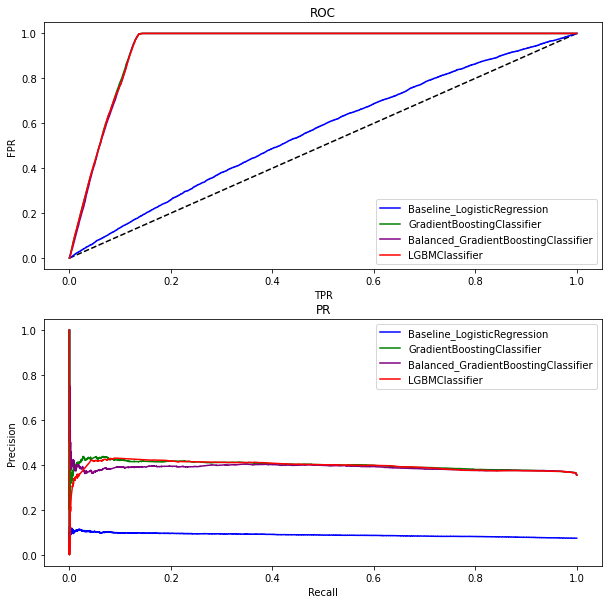

In [108]:
# Построим графики сравнения моделей
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)

f.set_figheight(10)
f.set_figwidth(10)

ax1 = plt.subplot(211)
ax1.set_title('ROC')
ax1.set_xlabel('TPR')
ax1.set_ylabel('FPR')

ax2 = plt.subplot(212)
ax2.set_title('PR')
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')

ax1.plot([0, 1], [0, 1], 'k--')

fpr, tpr, roc_thresholds = roc_curve(y_test, bl_y_pred)
precision, recall, pr_thresholds = precision_recall_curve(y_test, bl_y_pred)
ax1.plot(fpr, tpr, label='Baseline_LogisticRegression', color='blue')
ax2.plot(recall, precision, label='Baseline_LogisticRegression', color='blue')
print('Baseline_LogisticRegression: AUC_PR = %.3f' % auc(recall, precision))
print('Baseline_LogisticRegression: AUC_ROC = %.3f' % auc(fpr, tpr))

fpr, tpr, roc_thresholds = roc_curve(y_test, y_pred_1)
precision, recall, pr_thresholds = precision_recall_curve(y_test, y_pred_1)
ax1.plot(fpr, tpr, label='GradientBoostingClassifier', color='green')
ax2.plot(recall, precision, label='GradientBoostingClassifier', color='green')
print('GradientBoostingClassifier: AUC_PR = %.3f' % auc(recall, precision))
print('GradientBoostingClassifier: AUC_ROC = %.3f' % auc(fpr, tpr))

fpr, tpr, roc_thresholds = roc_curve(y_test, y_pred_2)
precision, recall, pr_thresholds = precision_recall_curve(y_test, y_pred_2)
ax1.plot(fpr, tpr, label='Balanced_GradientBoostingClassifier', color='purple')
ax2.plot(recall, precision, label='Balanced_GradientBoostingClassifier', color='purple')
print('Balanced_GradientBoostingClassifier: AUC_PR = %.3f' % auc(recall, precision))
print('Balanced_GradientBoostingClassifier: AUC_ROC = %.3f' % auc(fpr, tpr))

fpr, tpr, roc_thresholds = roc_curve(y_test, y_pred_3)
precision, recall, pr_thresholds = precision_recall_curve(y_test, y_pred_3)
ax1.plot(fpr, tpr, label='LGBMClassifier', color='red')
ax2.plot(recall, precision, label='LGBMClassifier', color='red')
print('LGBMClassifier: AUC_PR = %.3f' % auc(recall, precision))
print('LGBMClassifier: AUC_ROC = %.3f' % auc(fpr, tpr))
print()

ax1.legend(loc='lower right')
ax2.legend(loc='higher right');
plt.savefig('ROC_PR_curves.png', transparent=True)

### **Финальная модель и расчет порога**

In [109]:
# Для финальной модели выбираем LGBMClassifier
fpr, tpr, roc_thresholds = roc_curve(y_test, y_pred_3)
precision, recall, pr_thresholds = precision_recall_curve(y_test, y_pred_3)

Confusion matrix, without normalization
[[71720 11409]
 [   14  6521]]


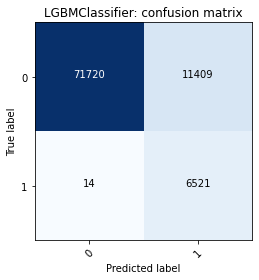

In [110]:
# Посмотрим на матрицу смежности
cm = confusion_matrix(y_test, y_pred_3 > 0.5)
tn, fn, fp, tp = cm[0][0], cm[1][0], cm[0][1], cm[1][1]
plot_confusion_matrix(cm, classes=['0', '1'], model_name='LGBMClassifier');

In [111]:
# Функция расчета порога в зависимости от прибыли на условных единицах
def choice_th(price_caller, price_service, nume):
  threshold = np.linspace(0.1, 1.0, num=nume)
  start = 0
  profit_list = []
  threshold_list = []
    
  for i in threshold:
    cm = confusion_matrix(y_test, y_pred_3 > i)
    tn, fn, fp, tp = cm[0][0], cm[1][0], cm[0][1], cm[1][1]
    cost_call = (fp + tp)*price_caller
    revenue = tp*price_service
    lost = fn*price_service
    profit = revenue-cost_call-lost
    if profit > start:
      start = profit
      profit_list.append(start)
      threshold_list.append(i)
    
  try:
    print(f'Максимальная прибыль: {max(profit_list)}')
    print(f'Порог: {threshold_list[profit_list.index(max(profit_list))]}')
  except ValueError:
    print('Вводные данные приводят к убытку.')
  

In [118]:
# Посчитаем выгоду на условных единицах
price_caller = 2       # затраты на обзвон 1-го абонента
price_service = 10     # стоимость подключаемой услуги

cost_call = (fp + tp)*price_caller
profit = tp*price_service
lost = fn*price_service

print(f'Затраты на обзвон: {cost_call} руб.')
print(f'Выручка: {profit} руб.')
print(f'Упущенная выгода: {lost} руб.')
print(f'Прибыль: {profit-cost_call-lost} руб.')
print()

# Найдем оптимальный порог
choice_th(2, 10, 100)

Затраты на обзвон: 35830 руб.
Выручка: 65200 руб.
Упущенная выгода: 150 руб.
Прибыль: 29220 руб.

Максимальная прибыль: 29220
Порог: 0.6818181818181818


Confusion matrix, without normalization
[[71734 11395]
 [   15  6520]]


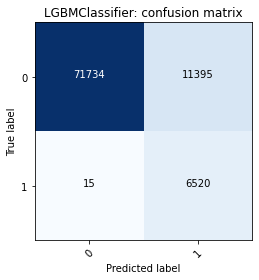

In [119]:
# Посмотрим на матрицу смежности с новым порогом
cm = confusion_matrix(y_test, y_pred_3 > 0.68)
tn, fn, fp, tp = cm[0][0], cm[1][0], cm[0][1], cm[1][1]
plot_confusion_matrix(cm, classes=['0', '1'], model_name='LGBMClassifier');
plt.savefig('confusion_matrix.png', transparent=True)

### **Сохранение модели**

In [ ]:
lgbm_fs_pipe = make_pipeline(
    f_prep_pipe,
    SelectFromModel(LogisticRegression(penalty='l2', random_state=RANDOM_STATE, solver='sag'), threshold=1e-2),
    lgb.LGBMClassifier(is_unbalance=True, max_depth=10, learning_rate=0.1, random_state=RANDOM_STATE)
)

lgbm_fs_pipe.fit(X_train, y_train)

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('columnselector',
                                  ColumnSelector(columns=['134', '168', '44',
                                                          '238', '1', '116',
                                                          '80', '193', '150',
                                                          '7', '84', '222',
                                                          '128', '94', '76',
                                                          '59', '195', '78',
                                                          '174', '133', '127',
                                                          '39', '51', '207',
                                                          '79', '6', '146',
                                                          '63', '237', '245', ...])),
                                 ('featureunion',
                                  FeatureUnion(transformer_list=[('numeric_features',
  

In [ ]:
lgbm_model = {
    'date': '12.02.2022',
    'ver': '1',
    'model': lgbm_fs_pipe
}

In [ ]:
with open('lgbm_model.pickle', 'wb') as f:
    pickle.dump(lgbm_model, f)

In [ ]:
with open('lgbm_model.pickle', 'rb') as f:
    lgbm_model_new = pickle.load(f)

print(lgbm_model_new['model'])

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('columnselector',
                                  ColumnSelector(columns=['134', '168', '44',
                                                          '238', '1', '116',
                                                          '80', '193', '150',
                                                          '7', '84', '222',
                                                          '128', '94', '76',
                                                          '59', '195', '78',
                                                          '174', '133', '127',
                                                          '39', '51', '207',
                                                          '79', '6', '146',
                                                          '63', '237', '245', ...])),
                                 ('featureunion',
                                  FeatureUnion(transformer_list=[('numeric_features',
  

### **Проверка**

In [ ]:
valid_data = pd.read_csv('id_merge_test.csv')

In [ ]:
valid_data.head()

,id,vas_id,buy_time,0,1,2,3,4,5,6,...,243,244,245,246,247,248,249,250,251,252
0,2905850,5.0,1546808400,326.930029,227.410888,312.989214,200.223202,307.571754,179.11821,-16.08618,...,-464.373846,-104.770792,-25.996269,-18.630448,-209.747724,-15.832889,-0.694428,-2.175933,-0.45614,0.0
1,31619,2.0,1546808400,-96.799971,100.290888,-62.040786,250.953202,-67.458246,229.84821,-16.08618,...,-977.373846,-613.770792,-25.996269,-37.630448,-306.747724,-25.832889,-0.694428,-12.175933,-0.45614,0.0
2,1427271,6.0,1546808400,-87.299971,-368.999112,339.439214,48.733202,334.021754,27.62821,-16.08618,...,928.626154,-548.770792,0.003731,-37.630448,116.252276,25.167111,-0.694428,38.824067,-0.45614,0.0
3,2162521,6.0,1546808400,-96.799971,-20.459112,-110.740786,-34.936798,-116.158246,-56.04179,-16.08618,...,-977.373846,-613.770792,-25.996269,-37.630448,-298.747724,-24.832889,-0.694428,-11.175933,-0.45614,0.0
4,1529304,6.0,1546808400,-96.799971,-394.439112,-110.740786,-447.046798,-116.158246,-468.15179,-16.08618,...,-977.373846,-613.770792,-25.996269,-37.630448,-306.747724,-25.832889,-0.694428,-12.175933,-0.45614,1.0


In [ ]:
y_pred_test = lgbm_model_new['model'].predict_proba(valid_data)[:,1]

In [ ]:
y_pred_test

array([8.10915635e-04, 1.62769212e-03, 8.89022251e-01, ...,
       8.81851642e-01, 1.47167241e-03, 1.40756101e-03])